### Intro

### Dataset Overview
- The dataset originates from a Kaggle project focused on classifying small pathology images. While the information on data collection methods is not clear, the [dataset description](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) provides valuable insights and clarification on duplicates. 
- The dataset comprises separate directories for train and test images. Ground truth labels are available in the "train_labels.csv" file, where a positive label signifies the presence of tumor tissue in the center 32x32px region.
- Although the exact dataset size is undisclosed (we'll discover in EDA), it is mentioned that duplicates were removed. The dataset maintains the same splits as the PCam benchmark.

### Project Goals and focus
- Project goal: Identify metastatic tissue in histopathologic scans of lymph node sections in the unseen (testing) dataset.
- Beyond Prediction: Gain insights and identify potential bottlenecks/challenges into the application of CNNs for processing and analyzing medical images in large volume. 


### Model Training Approach:
- Initial Base Run: A preliminary model was trained to establish a baseline.
- Tuning: Refinements were made, focusing on epoch numbers as the model was still learning.
- Transfer Learning: Utilized InceptionV3 for improved performance.

### A few highlights:
- EDA (Exploratory Data Analysis): Due to the dataset's size, a subset (1%) was used for efficient EDA. Noteworthy patterns and abnormal images were identified and excluded from training.
- Data Handling: Numpy arrays were employed for faster EDA, but image copies were later used for model training.
- Model Training Steps: A systematic approach involved an initial base run, tuning parameters, and implementing transfer learning with InceptionV3.


### Exploratory Data Analysis (EDA)

#### Part 1.1: Import Files, assisgn source directories, and Load Data

In [15]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import shutil
from glob import glob 
import cv2
import gc 
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, roc_curve,auc,recall_score, precision_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import InceptionV3, DenseNet121, NASNetMobile
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook,trange
%matplotlib inline

In [16]:
# Assign directory 
base_dir = 'data'  #path
label_path = os.path.join(base_dir, 'train_labels.csv')
train_path = os.path.join(base_dir,'train')
test_path = os.path.join(base_dir,'test')
sample_path = os.path.join(base_dir,'sample_submission.csv')

In [17]:
# Check numbers of files under train and test
print('samples in training data: ',len(os.listdir(train_path)))
print('samples in testingdata: ',len(os.listdir(test_path)))

samples in training data:  220025
samples in testingdata:  57458


In [32]:
# create a data frame to match training data image id and labels
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[2].split(".")[0]) # get image id to merge with training labels
train_labels = pd.read_csv(label_path)
df = df.merge(train_labels, on = "id") # merge labels and filepaths
df.head(2) 

,path,id,label
0,data/train/f0c2a0b8ef3024f407fa97d852d49be0215...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0,0
1,data/train/99ef485f205645918613cd04281098daa7c...,99ef485f205645918613cd04281098daa7c17819,1


In [33]:
# check if df is created correctly
# check image counts
print('df shape',df.shape)
# check null values
print('nulls :',df.isnull().sum().sum())
# check dup values
print("dups: ",df.duplicated().sum())

df shape (220025, 3)
nulls : 0
dups:  0


Positive labels in traing data:  0.40503124644926713


Text(0.5, 1.0, 'Label Distributions in 220025 training data')

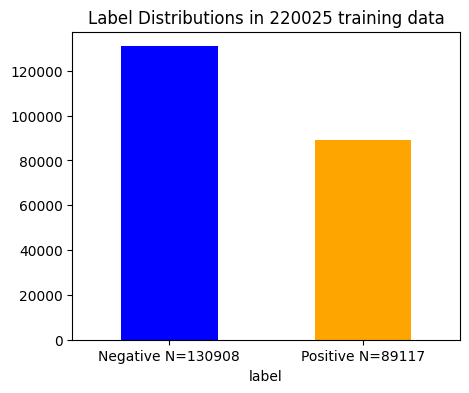

In [34]:
# Plot the label count histogram
print('Positive labels in traing data: ', train_labels['label'].value_counts()[1] /  (train_labels['label'].value_counts()[0] + train_labels['label'].value_counts()[1])  )
plt.figure(figsize=(5, 4))
ax = train_labels['label'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.xticks([0, 1], labels=[f"Negative N={train_labels['label'].value_counts()[0]}", f"Positive N={train_labels['label'].value_counts()[1]}"], rotation=0)
plt.title(f'Label Distributions in {train_labels.shape[0]} training data')


#### Part 1.2: Use partial of training data for EDA

In [35]:
df.head()

,path,id,label
0,data/train/f0c2a0b8ef3024f407fa97d852d49be0215...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0,0
1,data/train/99ef485f205645918613cd04281098daa7c...,99ef485f205645918613cd04281098daa7c17819,1
2,data/train/e2612e173abd0e8bb54a3c3db3f264b63d8...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb,1
3,data/train/6d1bb57c0606f05dbd75f90a8d9e21a57e1...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0,0
4,data/train/9c043ab2adadfeb758c71d21432fccd3e43...,9c043ab2adadfeb758c71d21432fccd3e43565c0,1


For partial exploratory data analysis (EDA), images are converted to NumPy arrays with uint8 data types for faster processing.

Note: Creating large NumPy arrays for extensive datasets is memory-intensive and may lead to resource constraints, especially when training deeper CNN architectures. To mitigate this, image files are copied to a designated directory for model training.

In [37]:
def load_data(pct, df):
    """This function loads percent of df and return image path/name and labels."""
    # Get the number of images to load
    n = int(pct * df.shape[0])
    
    # Randomly select n indices from the dataframe
    random_indices =  np.random.choice(df.shape[0], size=n, replace=False)
    
    # Allocate a numpy array for the images (n, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([n, 96, 96, 3], dtype=np.uint8)
    # Convert the labels to a numpy array
    y = np.squeeze(df['label'].values)[random_indices]

    # Read images using randomly selected indices
    for i, idx in enumerate(random_indices):
        X[i] = cv2.imread(df.loc[idx, 'path'])

    return n, X, y


#### Here we use 1% training data for EDA

In [38]:
# Load partical data
PCT = 0.01
n,sample_X,sample_y = load_data(pct = PCT, df=df)

In [39]:
# Take a look at image size and pixel info
print('Image shape: ',sample_X.shape)
print('Image maximum pixel value: ', sample_X.max())
print('Image minimum pixel value: ', sample_X.min())

Image shape:  (2200, 96, 96, 3)
Image maximum pixel value:  255
Image minimum pixel value:  0


In [40]:
# read image with flipping to rgb for visualization purpose
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

In [41]:
def plot_images(index, num_image_each):
    '''
    num_image_each needs to be an integer number >= 2
    '''
    fig, ax = plt.subplots(1, num_image_each, figsize=(20, 4))

    for i, idx in enumerate(index):
        path = os.path.join(train_path, train_labels.iloc[idx]['id'])
        ax[i].imshow(readImage(path + '.tif'))

    ax[0].set_ylabel('samples', size='large')
    
    plt.show()

random negative index:  [146631  33594  35697 123608  56608   1092  29163 143598]
random positive index:  [165904  37225 209936 109067 213873  61512   3224 136686]

plot some negative images


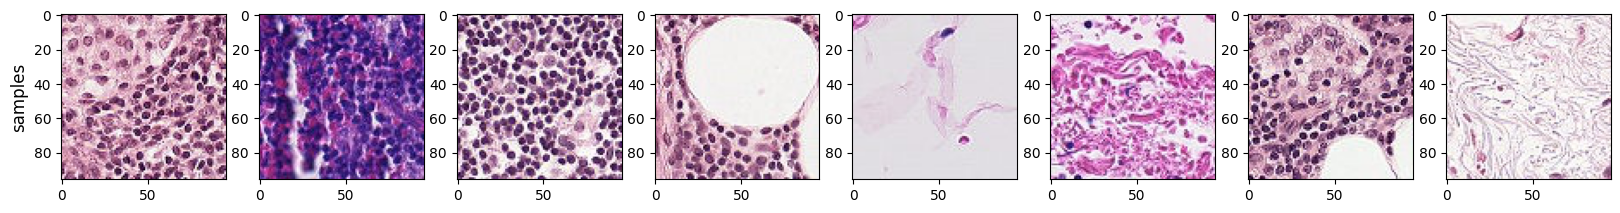


plot some positive images


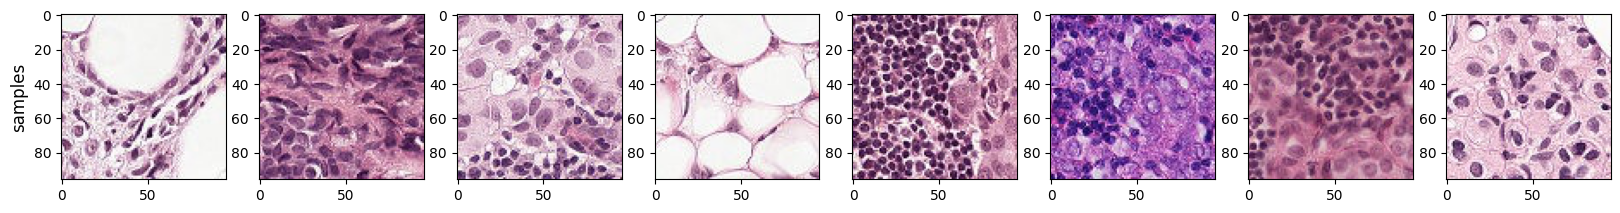

In [42]:
# plot some random negative and positive images  

# number of positive or negative each
num_image_each = 8

# Index of postive and negative samples
index_negative = np.random.choice(train_labels[train_labels['label']==0].index,num_image_each)
index_positive = np.random.choice(train_labels[train_labels['label']==1].index,num_image_each)
print("random negative index: ", index_negative)
print("random positive index: ", index_positive)

# Plot some negatives images
print("\nplot some negative images")
plot_images(index= index_negative, num_image_each=num_image_each)

# Plot some positive images
print("\nplot some positive images")
plot_images(index= index_positive, num_image_each=num_image_each)

#### Draw some plots to see distributions of pixels in different color chanels for positive and negative examples

In [43]:
# seperate positive and negaive sample and get means
pos_samples = sample_X[sample_y == 1]
neg_samples = sample_X[sample_y == 0]

# means brightness of positive and negative samples
pos_sample_avgs=np.mean(pos_samples, axis=(1,2,3))
neg_sample_avgs=np.mean(neg_samples, axis=(1,2,3))

# max brightness of positive and negative samples
pos_sample_maxs=np.max(pos_samples, axis=(1,2,3))
neg_sample_maxs=np.max(neg_samples, axis=(1,2,3))

# min brightness of positive and negative samples
pos_sample_mins=np.min(pos_samples, axis=(1,2,3))
neg_sample_mins=np.min(neg_samples, axis=(1,2,3))

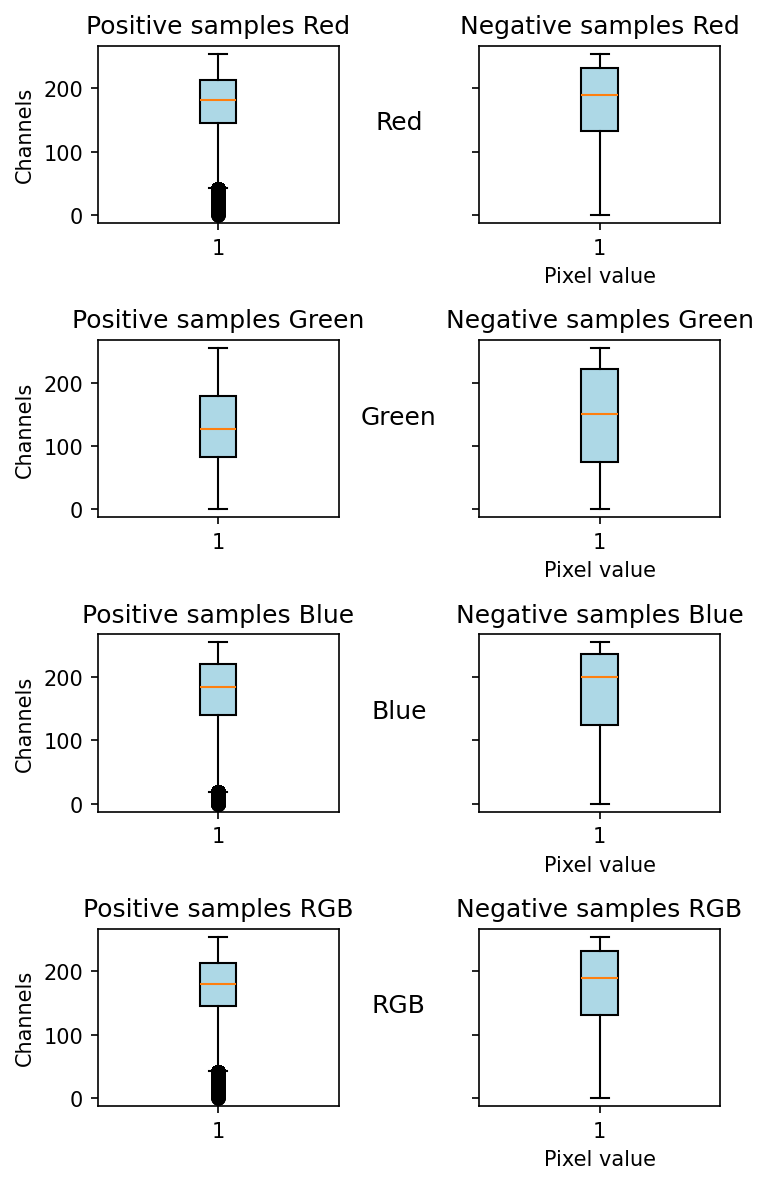

In [44]:
# plot box plots for positive and negative sample chanel distributions
channels = ["Red", "Green", "Blue", "RGB"]
sample_types = ["Positive", "Negative"]
samples = [pos_samples, neg_samples]

fig, axs = plt.subplots(4, 2, sharey=True, figsize=(5, 8), dpi=150)

for i, channel in enumerate(channels):
    for j, sample_type in enumerate(sample_types):
        # Get the corresponding samples
        current_samples = samples[j]

        # Create filled box plot (vertically)
        bp = axs[i, j].boxplot(current_samples[:, :, :, i % 3].flatten(), vert=True, patch_artist=True)
        axs[i, j].set_title(f"{sample_type} samples {channel}")

        # Set box color
        colors = ['lightblue', 'lightcoral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        # Set y-axis label for the last column
        if j == 1:
            axs[i, j].set_ylabel(channel, rotation='horizontal', labelpad=35, fontsize=12)

# Set common labels
for i in range(4):
    axs[i, 0].set_ylabel("Channels")
    axs[i, 1].set_xlabel("Pixel value")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

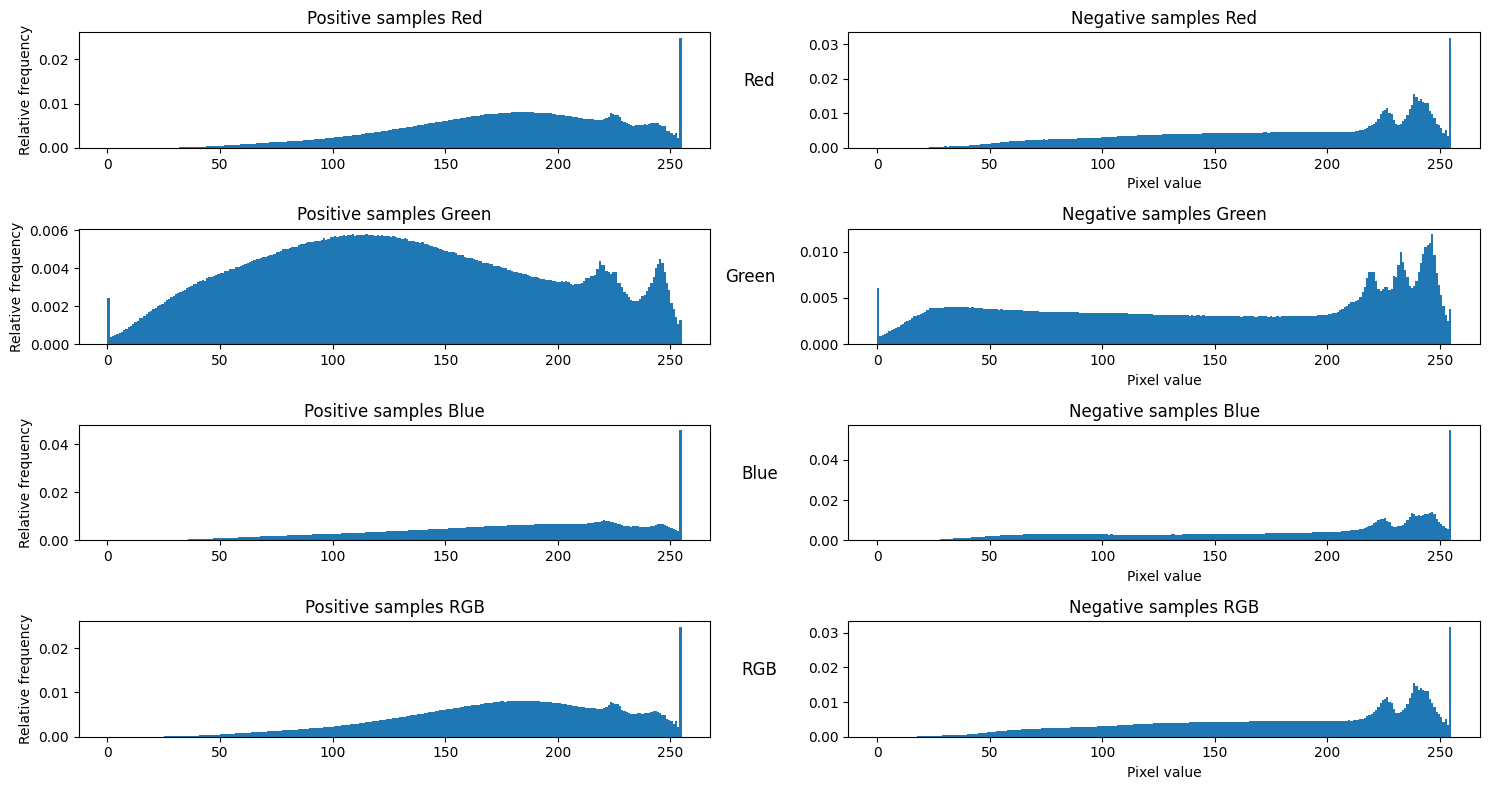

In [45]:
# plot histograms for positive and negative sample chanel distributions
nr_of_bins = 256
channels = ["Red", "Green", "Blue", "RGB"]
sample_types = ["Positive", "Negative"]
samples = [pos_samples, neg_samples]

fig, axs = plt.subplots(4, 2, figsize=(15, 8))

for i, channel in enumerate(channels):
    for j, sample_type in enumerate(sample_types):
        # Get the corresponding samples
        current_samples = samples[j]

        # Create histogram
        axs[i, j].hist(current_samples[:, :, :, i % 3].flatten(), bins=nr_of_bins, density=True)
        axs[i, j].set_title(f"{sample_type} samples {channel}")

        # Set y-axis label for the last column
        if j == 1:
            axs[i, j].set_ylabel(channel, rotation='horizontal', labelpad=35, fontsize=12)

# Set common labels
for i in range(4):
    axs[i, 0].set_ylabel("Relative frequency")
    axs[i, 1].set_xlabel("Pixel value")

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


Text(0, 0.5, 'Relative frequency')

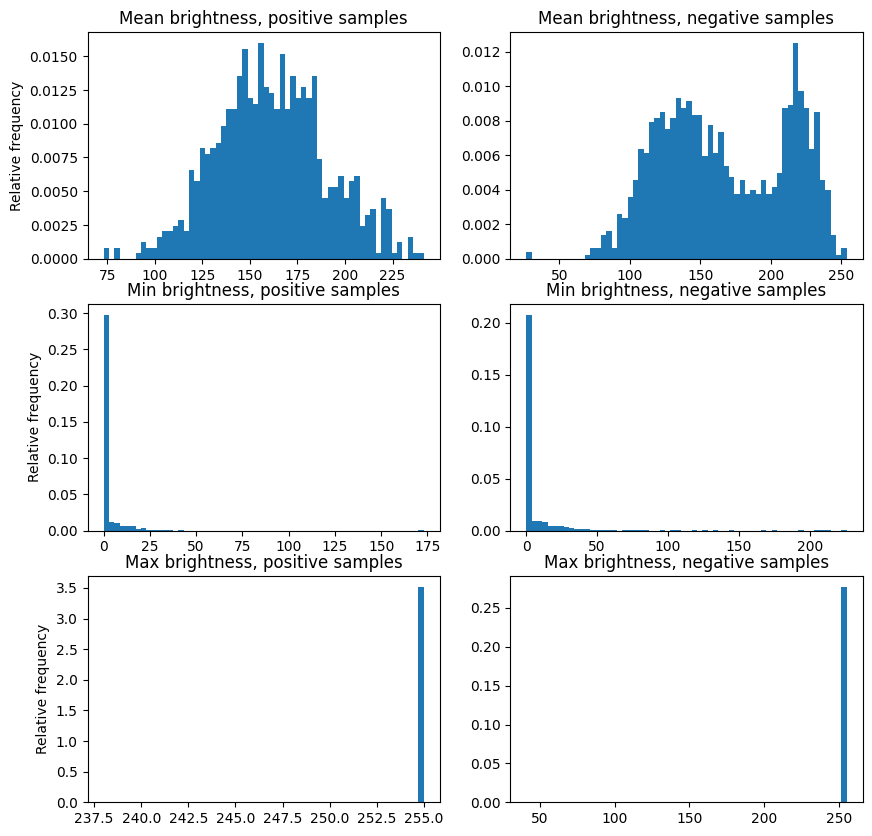

In [46]:
# Plot mean,min,max brightness histograms for positive and negative samples
fig,axs = plt.subplots(3,2,figsize=(10, 10))
axs[0,0].hist(pos_sample_avgs,bins= 60,density=True);
axs[0,1].hist(neg_sample_avgs,bins= 60,density=True);
axs[0,0].set_title("Mean brightness, positive samples");
axs[0,1].set_title("Mean brightness, negative samples");
axs[0,0].set_ylabel("Relative frequency")

axs[1,0].hist(pos_sample_mins,bins= 60,density=True);
axs[1,1].hist(neg_sample_mins,bins= 60,density=True);
axs[1,0].set_title("Min brightness, positive samples");
axs[1,1].set_title("Min brightness, negative samples");
axs[1,0].set_ylabel("Relative frequency")

axs[2,0].hist(pos_sample_maxs,bins= 60,density=True);
axs[2,1].hist(neg_sample_maxs,bins= 60,density=True);
axs[2,0].set_title("Max brightness, positive samples");
axs[2,1].set_title("Max brightness, negative samples");
axs[2,0].set_ylabel("Relative frequency")


##### There are some abnormal pictures discovered during the EDA, here are some samples.

In [47]:
# Calculate brightness for each image. 
brightest_values = np.max(sample_X, axis=(1, 2, 3))
darkest_values = np.min(sample_X, axis=(1, 2, 3))

# Find indices of images with abnormal brightness
# Note the threshold I found after later abnormal image inspectaion on all images.
abnormal_brightness_indices_sx = np.where(
    (brightest_values < 75) | (darkest_values  >  180)
)[0]


print( 'abnormal_indices in sample X: ',abnormal_brightness_indices_sx)
print( 'number of abnormal_indices in sample X: ',abnormal_brightness_indices_sx.shape[0])

abnormal_indices in sample X:  [  13  242  259  323  885 1524 1734]
number of abnormal_indices in sample X:  7


Image 13 brightest pixel value is 255, darkest pixel value is 193
Image 242 brightest pixel value is 45, darkest pixel value is 13
Image 259 brightest pixel value is 228, darkest pixel value is 204
Image 323 brightest pixel value is 41, darkest pixel value is 19
Image 885 brightest pixel value is 233, darkest pixel value is 212
Image 1524 brightest pixel value is 251, darkest pixel value is 226
Image 1734 brightest pixel value is 234, darkest pixel value is 208


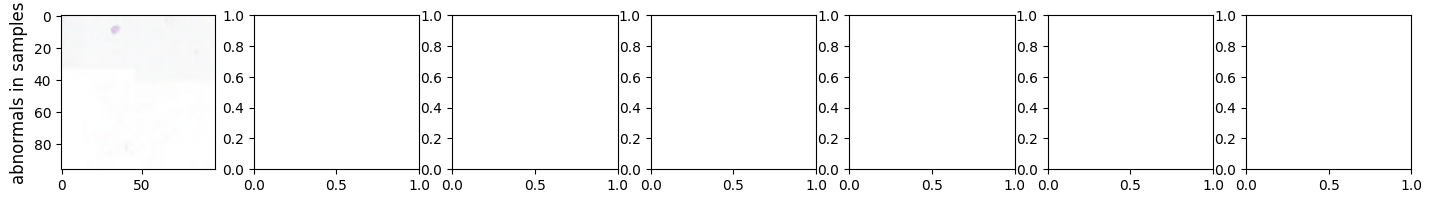

In [48]:
# check brightest and darkest pixel of abnormal images in samples
for index in abnormal_brightness_indices_sx: 
    print(f'Image {index} brightest pixel value is {np.max(sample_X[index,:,:,:])}, darkest pixel value is {np.min(sample_X[index,:,:,:])}')
   
# Plot abnormal images in samples
fig, ax = plt.subplots(1, len(abnormal_brightness_indices_sx), figsize=(2.5 * len(abnormal_brightness_indices_sx) , 2))

for i, idx in enumerate(abnormal_brightness_indices_sx):
    ax[i].imshow(sample_X[idx,:,:,:])
    ax[0].set_ylabel('abnormals in samples', size='large')
    plt.show()

### EDA Summary:
    
- There are **220,025 samples** in training data and **57,458** samples in testing data. 
- **Train/Test split: 80%/20%**.
- There are **130,908 negative and 89,117 postitive labels.  Positive lable %: 41%**.
- **Images has shape (96, 96, 3)**
- **Pixal values range from 0 to 255**. 
- **Negative samples seems to have more brighter (200-250 higer value) pixels in red, green, blue, and RGB mixed chanels**.
- **There are a few abnormal images**. Some image's smallest pixel values seems high, meaning they are too bright. Also, maybe a few images are too dark.
    
### Some preprocessing/cleaning idea based on EDA:
- Normalize data using /.255. I will do this in image augmentation though.
- Exclude the abnormal images when preparing the data for training. 
    

In [49]:
# the abonormal images indices (hard-coded)

abnormal_brightness_indices = [563, 1184, 1501, 2000, 2817, 3872, 4067, 4079, 
                               4204, 4382, 4660, 5190, 5636, 6520, 6907, 7012, 
                               7063, 7173, 8134, 8325, 8406, 8525, 9010, 9307, 
                               9390, 9415, 9764, 9832, 10200, 10337, 11326, 
                               11915, 12771, 12965, 13724, 13781, 13801, 13945, 
                               14335, 14742, 16689, 16899, 17809, 18386, 18613, 
                               18743, 18810, 18842, 19022, 19336, 19456, 19579, 
                               20019, 20243, 20294, 20687, 21713, 21844, 22923, 
                               23084, 23135, 23263, 23306, 23396, 23429, 23962, 
                               25503, 25930, 25966, 26266, 26758, 26771, 27134, 
                               27188, 27888, 28005, 29274, 30035, 30323, 30481, 
                               30754, 31352, 32016, 32212, 32230, 33071, 33392, 
                               33946, 34005, 34921, 35086, 35763, 35875, 36062, 
                               36452, 36614, 36760, 36881, 37404, 37613, 37645, 
                               37842, 38089, 38117, 38127, 38387, 38412, 38414, 
                               39151, 39191, 40038, 40084, 40884, 41171, 41442, 
                               41749, 41753, 42940, 43235, 43236, 43370, 43526, 
                               43561, 43689, 43818, 44236, 45707, 46058, 47419, 
                               48056, 48270, 49635, 49889, 50295, 50638, 51614, 
                               52251, 53086, 53427, 53976, 54446, 54638, 54699, 
                               54990, 55000, 55351, 55515, 56591, 56675, 57504, 
                               57552, 57674, 58043, 58090, 58625, 58835, 59690, 
                               59823, 61334, 61379, 61784, 61857, 62393, 62534, 
                               62926, 62935, 63407, 63672, 65585, 66062, 66656, 
                               66741, 66927, 67452, 67502, 67903, 68159, 68220, 
                               68583, 68607, 68709, 69071, 71056, 72897, 72979,
                               73372, 73666, 73822, 74334, 74386, 74536, 74573, 
                               74953, 75278, 75379, 75745, 75963, 76168, 76746, 
                               76841, 77341, 78310, 78668, 78798, 79156, 79894,
                               80524, 81094, 81098, 81320, 81358, 81408, 82393,
                               82518, 82852, 82945, 83303, 83354, 83393, 83479,
                               83559, 83651, 84554, 84670, 84843, 85021, 85154, 
                               85329, 85503, 86727, 87077, 87873, 87961, 88128, 
                               88459, 88581, 89759, 89969, 90442, 90585, 91986, 
                               92803, 93235, 93709, 94200, 94521, 95061, 95276, 
                               95387, 95468, 95530, 95583, 95713, 95749, 96035, 
                               96640, 96929, 98927, 99296, 99298, 99458, 99806, 
                               99927, 100380, 100402, 100605, 100872, 101543, 
                               102082, 102620, 102621, 102712, 102983, 104141, 
                               104192, 104290, 104634, 104948, 105141, 105326, 
                               106057, 106439, 106867, 106929, 107026, 107212, 
                               107304, 107776, 107990, 108110, 108674, 108920, 
                               109101, 109393, 110252, 110412, 111151, 112387, 
                               112620, 112621, 113174, 113192, 113553, 114720, 
                               114790, 114829, 115397, 115582, 116799, 117191, 
                               117287, 117913, 118377, 118507, 118610, 118776, 118841, 119605, 119616, 119789, 120325, 120532, 121005, 121226, 121275, 121380, 121631, 122261, 122391, 122864, 123934, 124240, 124444, 124626, 125824, 126393, 126487, 126969, 127079, 127196, 127335, 127460, 128059, 128263, 128451, 128973, 129338, 129416, 129806, 130123, 130194, 130257, 130390, 130754, 131060, 131557, 131992, 132402, 132404, 132812, 133154, 133211, 133297, 134614, 134666, 135599, 135615, 135963, 136110, 136477, 137134, 137851, 137963, 138273, 138381, 138484, 138859, 139331, 139744, 139817, 139920, 140298, 140399, 141505, 142139, 142468, 142889, 143209, 143309, 143518, 144010, 144265, 144534, 145298, 145955, 146020, 146522, 147783, 147952, 148527, 148545, 149393, 150294, 150759, 151089, 152243, 152549, 152837, 153256, 153651, 154094, 154133, 154238, 154270, 154316, 154729, 155536, 155865, 156253, 156422, 156512, 157071, 157228, 157581, 158455, 158705, 158929, 159130, 159801, 160097, 160480, 160588, 161045, 161076, 161195, 161303, 161308, 161379, 161443, 162186, 162323, 162487, 162796, 162797, 163116, 163449, 163932, 164002, 164046, 164052, 164077, 164803, 164944, 165394, 166311, 166593, 167008, 167058, 167767, 167825, 167864, 167871, 168099, 168270, 168456, 168649, 168791, 168916, 168965, 169061, 169068, 169210, 169227, 169355, 169583, 169903, 169976, 169981, 171091, 171456, 171564, 171975, 172152, 172427, 172437, 172764, 172930, 173665, 174007, 176035, 176314, 176474, 176507, 176653, 177333, 177629, 177955, 178367, 178552, 179100, 179995, 180425, 180441, 180761, 181059, 181208, 181280, 181376, 181591, 181871, 181964, 182028, 182140, 182439, 182459, 182777, 182788, 182858, 183068, 183462, 183901, 185126, 185474, 185743, 185935, 186136, 186217, 186687, 187048, 187650, 188092, 188603, 188964, 188981, 189406, 189854, 190096, 190141, 190482, 190589, 190899, 190913, 191313, 191407, 191684, 191902, 191908, 192341, 192456, 192477, 192569, 193074, 193194, 193618, 193623, 193840, 193844, 193879, 194220, 194275, 195125, 196150, 196775, 197231, 197234, 198170, 198226, 198325, 198356, 199282, 199308, 199634, 200032, 200286, 201505, 201625, 201990, 202078, 202103, 202167, 203077, 203493, 203656, 203741, 204340, 204405, 204624, 205096, 205142, 205274, 205585, 205687, 205721, 206409, 207278, 207917, 208118, 208354, 208505, 209273, 209725, 210278, 210915, 211026, 211056, 211398, 211546, 211585, 212253, 212672, 212872, 212923, 213383, 213575, 213581, 213944, 214139, 214809, 214824, 215062, 215389, 216153, 216309, 216557, 216759, 217036, 217188, 217258, 217345, 217380, 217563, 217685, 217993, 218102, 218511, 219449, 219534, 219598]

#### Part 2: Model Building and training

#### Part 2.1: Copy all normal images to directories, with train test split

#### Loading the images while excluding the abnormal ones.



In [50]:
# drop abnormal images indices in df
df.drop(abnormal_brightness_indices, inplace=True)
print('df size after removing abnormal images: ', df.shape[0])

df size after removing abnormal images:  219387


In [51]:
# train test split
df_train, df_val = train_test_split(df, test_size=0.10, random_state=100)

In [52]:
# reset index using id
df.set_index('id', inplace=True)


In [56]:
# Create directories for model augmentation
work_dir ='data/working/data'
train_dir =os.path.join(work_dir,'train')
val_dir=os.path.join(work_dir,'val')

if os.path.exists(work_dir):# remove the entire directory and its contents if already exist
    shutil.rmtree(work_dir)

for fold in [train_dir, val_dir]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf)) # this will create necessary parent directories as well :)       

In [57]:
# Copy all files to train and validation directies
 
# copy train files 
for id in df_train['id'].values:
    fn =id +'.tif'
    label = str(df.loc[id,'label']) 
    source_dir_fn=os.path.join(train_path, fn)
    train_dir_fn=os.path.join(train_dir,label,fn)
    shutil.copyfile(source_dir_fn,train_dir_fn )
    
# copy validation files
for id in df_val['id'].values:
    fn =id +'.tif'
    label = str(df.loc[id,'label']) 
    source_dir_fn =os.path.join(train_path, fn)
    val_dir_fn =os.path.join(val_dir,label,fn)
    shutil.copyfile(source_dir_fn,val_dir_fn )

In [58]:
# check image counts in Training and validation directories

#Training
print('Positive images in training directory: ', len(os.listdir(os.path.join(train_dir, '1'))))
print('Negative images in training directory: ',len(os.listdir(os.path.join(train_dir, '0'))))
print('% Positive images in training directory: ',len(os.listdir(os.path.join(train_dir, '1'))) / (len(os.listdir(os.path.join(train_dir, '0'))) + len(os.listdir(os.path.join(train_dir, '1'))) ),'\n')

# Validation
print('Positive images in validation directory: ', len(os.listdir(os.path.join(val_dir, '1'))))
print('Negative images in validation directory: ',len(os.listdir(os.path.join(val_dir, '0'))))
print('% Positive images in validation directory: ',len(os.listdir(os.path.join(val_dir, '1'))) / (len(os.listdir(os.path.join(val_dir, '0'))) + len(os.listdir(os.path.join(val_dir, '1'))) ), '\n')

# Training vs. Validation
print('Images in Training directory: ', len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0'))) )
print('Images in  validation directory: ', len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0'))) )
print('% Training images: ', (len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0')))) / (len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0')))+len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0'))) )    )
print('\nTotal images: ',  (len(os.listdir(os.path.join(train_dir, '1'))) + len(os.listdir(os.path.join(train_dir, '0')))+len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0'))) )    )


Positive images in training directory:  79902
Negative images in training directory:  117546
% Positive images in training directory:  0.40467363559013003 

Positive images in validation directory:  8959
Negative images in validation directory:  12980
% Positive images in validation directory:  0.40835954236747346 

Images in Training directory:  197448
Images in  validation directory:  21939
% Training images:  0.8999986325534329

Total images:  219387


In [59]:
# Collect garbage to free up memory
del pos_samples 
del neg_samples 
del pos_sample_avgs 
del neg_sample_avgs 
del pos_sample_mins
del neg_sample_mins 
del pos_sample_maxs 
del neg_sample_maxs
del df
gc.collect()

144058

## InceptionV3 
#### Insights from InceptionV3 Architecture:
- Lower Layers:
  - Basic convolutional Operations: such as Conv2d_1a_3x3, Conv2d_2a_3x3, and Conv2d_2b_3x3 
  - Fundamental local features extractraction: such as edges, textures, colors, and gradients
  - Simple Shapes and Contrast: In addition to low-level features, identify simple shapes and capturing contrast variations in the images.
- Intermediate Layers:
  - Mixed Operations:  blocks such as Mixed_3a, Mixed_4a, and Mixed_5a, combining different filter sizes and operations in parallel.
  - Repetitive Structures capturing: such as repetitive structures within the images, recognizing patterns that repeat across the dataset.
  - Color Variations and Relationships: further understand color variations and establish hierarchical relationships between different parts of objects in the images.
  - Object Boundaries: delineating object boundaries, enhancing the model's ability to recognize distinct objects and their spatial relationships.
- Deeper Inception Blocks:
  - Mixed Operations: Blocks such as Mixed_5b, Mixed_6a, Mixed_7a
  - Complex Shapes and Structures: improved understanding of complex shapes and intricate structures present in the images.
  - Discrimination of Patterns: enhanced discrimination of complex patterns, distinguish fine-grained details and textures.

#### Adaptation Plan:
- Feature Extraction:
  - Utilize earlier blocks for low-level features 
- Intermediate Layers Modification:
  - Introduce extra convolution layers for medical image nuances.
  - Post 'mixed2' layer in InceptionV3, the feature map is roughly (9 * 9). Add padding to prevent rapid size reduction (retain spatial information)
- Enhancements with 1x1 Filters:
  - Incorporate 1x1 filters for improved learning.
- Handle Overfitting:
  - Batch normalization
  - Dropout layers.
- Image Augmentations for better generalization.

## Modeling - transfer learning with Inception V3

In [ ]:
# Load the InceptionV3 model
incept_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the weights of the layers.
for layer in incept_model.layers:
    layer.trainable = False

# get the last_layer of inception we want to use
last_layer = incept_model.get_layer('mixed2')

# Create a new model using the functional API
base_model = Model(inputs=incept_model.input, outputs=last_layer.output)

# Add layers to the model
model = Sequential([
    base_model,
    
    Conv2D(64, (3, 3), padding='same', activation='relu'), # keep the width and height
    BatchNormalization(),
    Conv2D(64, (1, 1),activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),            
    Conv2D(64, (1, 1), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

# Print the model summary
model.build(input_shape=(None, 96, 96, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 9, 9, 288)      │       993,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_282 (Conv2D)             │ (None, 9, 9, 64)       │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_282         │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_283 (Conv2D)             │ (None, 9, 9, 64)       │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_283         │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_284 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_284         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_285 (Conv2D)             │ (None, 7, 7, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_285         │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_286         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_287         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665,761 (6.35 MB)

 Trainable params: 671,553 (2.56 MB)

 Non-trainable params: 994,208 (3.79 MB)

In [ ]:
#Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9 
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=[AUC()]
)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

# data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
)

datagen_val = ImageDataGenerator(
    rescale=1./255,
)

train_generator = datagen.flow_from_directory(directory=train_dir,
                                            batch_size=BATCH_SIZE,
                                            class_mode='binary',
                                            target_size=(96, 96))

val_generator = datagen_val.flow_from_directory(directory=val_dir, 
                                                batch_size=BATCH_SIZE, 
                                                class_mode='binary',
                                               target_size=(96,96))

steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Found 197448 images belonging to 2 classes.
Found 21939 images belonging to 2 classes.


/Users/abdelrahman/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 299s 48ms/step - auc: 0.9008 - loss: 0.3828 - val_auc: 0.9575 - val_loss: 0.2721
Epoch 2/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 319s 52ms/step - auc: 0.9459 - loss: 0.2848 - val_auc: 0.9679 - val_loss: 0.2247
Epoch 3/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 313s 51ms/step - auc: 0.9554 - loss: 0.2580 - val_auc: 0.9692 - val_loss: 0.2267
Epoch 4/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 344s 56ms/step - auc: 0.9599 - loss: 0.2444 - val_auc: 0.9713 - val_loss: 0.2238
Epoch 5/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 307s 50ms/step - auc: 0.9626 - loss: 0.2359 - val_auc: 0.9725 - val_loss: 0.2228
Epoch 6/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 291s 47ms/step - auc: 0.9636 - loss: 0.2334 - val_auc: 0.9730 - val_loss: 0.2188
Epoch 7/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 288s 47ms/step - auc: 0.9644 - loss: 0.2295 - val_auc: 0.9733 - val_loss: 0.2131
Epoch 8/10
6171/6171 ━━━━━━━━━━━━━━━━━━━━ 294s 48ms/step - auc: 0.9643 - loss: 0.2301 - val_auc: 0.9737 - val_loss: 0.2106
Epoch 9/10
6171/

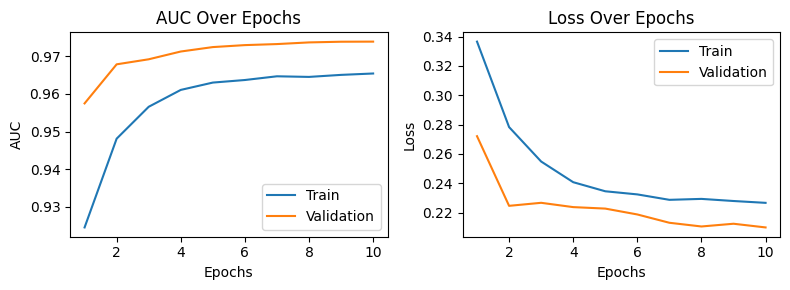

In [ ]:
# Plot metrics
epochs = np.arange(1, EPOCHS+1)
plt.figure(figsize=(8, 3))

# AUC
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['auc'], label='Train')
plt.plot(epochs, history.history['val_auc'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC Over Epochs')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train')
plt.plot(epochs, history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()


### Model Performance:
- Achieved satisfactory training AUC of around 0.96 and a commendable validation AUC of 0.97 in the last epoch.
- validation AUC plateaued after 8 epochs.

### Next Steps:
- Model evaluation, focusing on metrics such as precision, recall, F1 score, and confusion matrix to gain a holistic understanding of the model's performance. This approach ensures a balanced assessment of the model's predictive capabilities beyond AUC, providing insights into its precision, recall, and overall classification effectiveness.

In [ ]:
# Predict validation set 
samples_val = len(os.listdir(os.path.join(val_dir, '1'))) + len(os.listdir(os.path.join(val_dir, '0')))
val_generator_for_pred = datagen_val.flow_from_directory(directory=val_dir, 
                                                batch_size=1, 
                                                class_mode='binary',
                                               target_size=(96,96),
                                                shuffle=False)


val_predictions = model.predict(val_generator_for_pred, steps=samples_val, verbose=1)


Found 21939 images belonging to 2 classes.
21939/21939 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step


In [68]:
# Actual vs. predicted classes for validation set

# actual
val_labels = val_generator_for_pred.classes

# convert probability to classes using 0.5 shreshold
binary_val_predictions = (val_predictions > 0.5).astype(int)


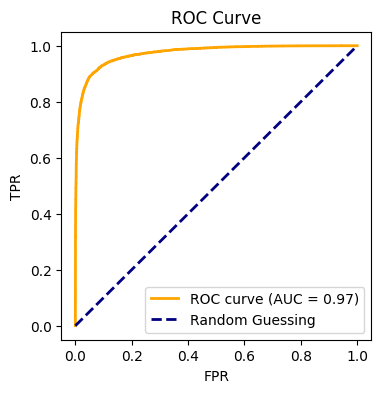

In [69]:
# Plot ROC curve

# Calculate AUC
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)
roc_auc = auc(fpr, tpr)

# Plot 
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [70]:
# Get recall, predicision, F1, accuracy scores for validation set
recall = recall_score(val_labels, binary_val_predictions)
precision = precision_score(val_labels, binary_val_predictions)
F1 = f1_score(val_labels, binary_val_predictions)
acc= accuracy_score(val_labels, binary_val_predictions)

print("Recall on validation set:", recall)
print("Precision on validation set:", precision)
print("F1 score n on validation set:", F1)
print("Accuracy score n on validation set:", acc)

Recall on validation set: 0.8377051010157384
Precision on validation set: 0.9521695001268714
F1 score n on validation set: 0.8912772400688795
Accuracy score n on validation set: 0.9165413191120835


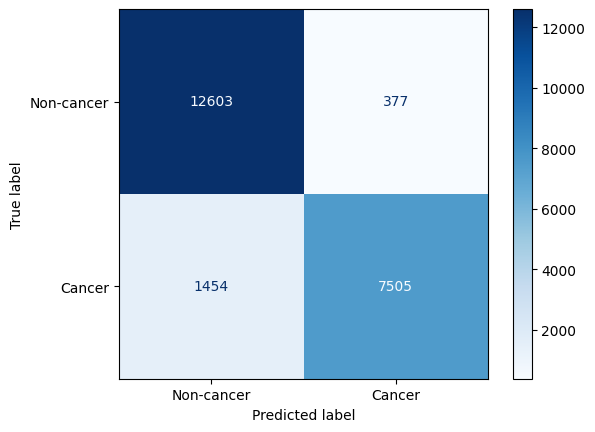

In [71]:
# Plot confusion matrix
cm = confusion_matrix(val_labels, binary_val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-cancer', 'Cancer'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

### Final Model Reflection:

- Recall Concerns:
  - Recall around 83% is suboptimal for cancer detection.
  - 1450+ cancer images misclassified as non-cancer signals a notable false-negative rate.
- Importance of Recall:
  - High recall crucial in cancer detection.

- Future Considerations:
  - Boosting recall through class weight adjustment or model fine-tuning. Emphasizes the need to strike a balance between overall model performance and sensitivity in critical scenarios like cancer detection.

In [72]:
# Copy files to test_dir

# Directories
test_source_path = os.path.join(base_dir,'test')
test_images = os.listdir(test_path)
test_dir=os.path.join(work_dir,'test')
test_dir_images=os.path.join(test_dir,'Pos and neg images') # put all images directly to work_dir won't work! Need to put images under a folder in test_dir 

# remove the entire directory and its contents if already exist
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
# Make directories   
os.makedirs(test_dir)
os.makedirs(test_dir_images)

# Copy images
for fn in test_images:
    source_fns = os.path.join(test_source_path, fn)
    test_fns = os.path.join(test_dir_images, fn)
    shutil.copyfile(source_fns,test_fns)



In [73]:
# Check number of images under test dir
print(len(os.listdir(test_dir)))
print(len(os.listdir(test_source_path)))

1
57458


In [ ]:
# Test data generator
datagen_test = ImageDataGenerator(
    rescale=1./255)

test_generator = datagen_test.flow_from_directory(directory=test_dir, 
                                                batch_size= BATCH_SIZE, 
                                                class_mode=None,
                                               target_size=(96,96),
                                                shuffle=False)

test_predictions = model.predict(test_generator, verbose=1)

Found 57458 images belonging to 1 classes.


/Users/abdelrahman/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 61s 34ms/step


In [75]:
# Create test df
test_df= pd.DataFrame({'id':  test_generator.filenames,'label': test_predictions.flatten()})
test_df.head(1)

,id,label
0,Pos and neg images/00006537328c33e284c973d7b39...,0.991978


### The id for submission should not have '.tif'

In [ ]:
# Get rid of '.tif' in 'id' column
def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

test_df['id'] = test_df['id'].apply(extract_id)

test_df.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.991978
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.995288
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.429003
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.606366
4,000270442cc15af719583a8172c87cd2bd9c7746,0.000021


In [77]:
# submition
test_df.to_csv('submission.csv', index=False)

### Conclusion and take aways
- Data Handling Challenges: Managing large-scale datasets presents significant challenges. Various optimization techniques were explored, including converting images to int8 NumPy arrays for efficient loading. However, this approach proved to be memory-intensive, impacting model training feasibility.
- Impact of Transfer Learning: Incorporating transfer learning significantly enhanced model performance. Pretrained models, trained on diverse and extensive datasets, introduced external knowledge, enabling the detection of intricate patterns in medical images. Additionally, transfer learning helped mitigate overfitting, improving generalization.
-	Model Evaluation Considerations: While AUC-ROC is a robust evaluation metric, it introduces complexity during model compilation as it considers performance across all classification thresholds. In contrast, practical metrics such as recall, precision, and the confusion matrix typically rely on a fixed threshold (e.g., 0.5), making them more interpretable for real-world applications.

### Future Improvements:

- Exploring Alternative Metrics: Experimenting with alternative metrics, such as accuracy, could provide a different perspective on model performance. However, achieving a balanced dataset would be crucial in this context.

- Optimizing Region of Interest: Focusing on the central 32x32 region, where cancer detection is most relevant, may involve cropping images to enhance model efficiency and effectiveness.
- Addressing testing AUC discrepancy:
  - Experimenting with increased augmentation and dropout techniques to reduce overfitting.
  - Consider expanding the validation set size for a more representative evaluation of model generalization.

